<a href="https://colab.research.google.com/github/brainmentorspvtltd/IGDTU_ImageProcessingTF/blob/main/IG_Siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Flatten, MaxPool2D, Dense, Dropout, Lambda
from keras import backend as K

In [2]:
from tensorflow.keras.datasets import mnist

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
x_train.shape

(60000, 28, 28)

In [5]:
x_test.shape

(10000, 28, 28)

In [6]:
y_train[0]

5

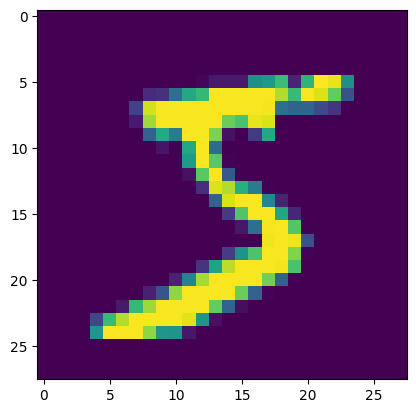

In [7]:
plt.imshow(x_train[0])
plt.show()

In [8]:
def showImages(X, y=None, index=100, numImg = 4):
  for i in range(numImg):
    fig = plt.subplot(4, 4, i+1)
    fig.axis("off")
    plt.imshow(X[index+i], cmap="Greys")
    plt.title(y[index+i])
  plt.show()

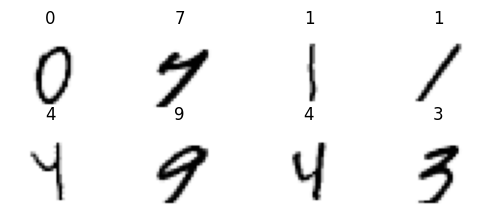

In [9]:
showImages(x_train, y_train, index=1000, numImg=8)

In [10]:
index = [np.where(y_train == i)[0] for i in range(10)]

In [11]:
index

[array([    1,    21,    34, ..., 59952, 59972, 59987]),
 array([    3,     6,     8, ..., 59979, 59984, 59994]),
 array([    5,    16,    25, ..., 59983, 59985, 59991]),
 array([    7,    10,    12, ..., 59978, 59980, 59996]),
 array([    2,     9,    20, ..., 59943, 59951, 59975]),
 array([    0,    11,    35, ..., 59968, 59993, 59997]),
 array([   13,    18,    32, ..., 59982, 59986, 59998]),
 array([   15,    29,    38, ..., 59963, 59977, 59988]),
 array([   17,    31,    41, ..., 59989, 59995, 59999]),
 array([    4,    19,    22, ..., 59973, 59990, 59992])]

In [12]:
def showPair(X, y, image):
  subplot = plt.subplot(1,2,1)
  plt.imshow(X[image][0])
  subplot.axis("off")
  subplot = plt.subplot(1,2,2)
  subplot.axis("off")
  plt.imshow(X[image][1])
  plt.title(y[image])
  plt.show()

In [13]:
# Create Pairs - we need to pass a pair of objects
# and a label indicating that objects are equal or not

# min_pairs - how many equal pairs as min we want in the dataset
def create_pairs(X, y, min_pairs=2000):
  pairs = []
  labels = []
  equal_items = 0
  # we have 10 classes
  # index[1] - all positions with values equals to 1
  # index[2] - all positions with values equals to 2
  index = [np.where(y == i)[0] for i in range(10)]

  for item in range(len(X)):
    if equal_items < min_pairs:
      random_index = np.random.randint(len(index[y[item]]))
      num_pairs = index[y[item]][random_index]
      equal_items += 1
    else:
      num_pairs = np.random.randint(len(X))

    labels += [y[item] == y[num_pairs]]
    pairs += [[X[item], X[num_pairs]]]

  return np.array(pairs), np.array(labels).astype("float32")

In [14]:
train_pairs, train_labels = create_pairs(x_train, y_train)
test_pairs, test_labels = create_pairs(x_test, y_test)

In [15]:
train_pairs.shape

(60000, 2, 28, 28)

In [16]:
train_labels.shape

(60000,)

In [17]:
train_labels[0]

1.0

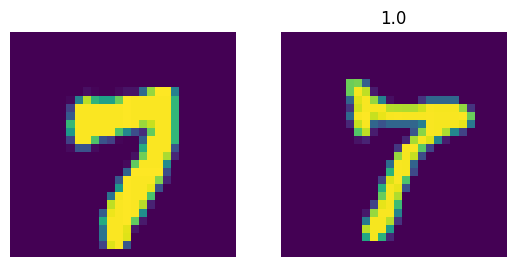

In [18]:
showPair(train_pairs, train_labels, 1343)

In [36]:
def init_base_model(input_shape=(28,28,1)):
  model = Sequential()
  model.add(Conv2D(32, (3,3), activation="relu", input_shape=input_shape))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Conv2D(16, (3,3), activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Flatten())
  model.add(Dense(128, activation="relu"))
  model.add(Dense(64, activation="relu"))
  model.add(Dense(32, activation="relu"))
  return model

In [37]:
base_model = init_base_model()

In [38]:
input_layer_left = Input(shape=(28,28,1), name="left_input")
vec_output_left = base_model(input_layer_left)

input_layer_right = Input(shape=(28,28,1), name="right_input")
vec_output_right = base_model(input_layer_right)

In [39]:
# Loss Functions - Constrastive Loss / Triplet Loss
def euclidean_distance(vectors):
  x,y = vectors
  sum_square = K.sum(K.square(x-y), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))

def euclidean_distance_output_shape(shapes):
  shape_1, shape_2 = shapes
  return (shape_1[0], 1)

def constrastiveLossWrapper(margin):
  def contrastiveLoss(y_true, y_pred):
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return (y_true * square_pred + (1 - y_true) * margin_square)
  return contrastiveLoss

In [40]:
output = Lambda(euclidean_distance, name="output_layer",
                output_shape = euclidean_distance_output_shape)([vec_output_left, vec_output_right])

model = Model(inputs = [input_layer_left, input_layer_right], outputs = output)

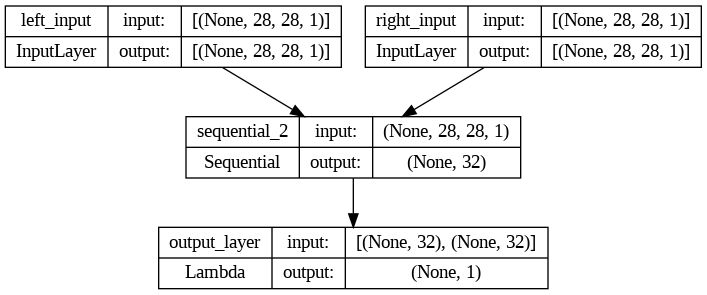

In [41]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [42]:
# def calc_acc(pred, labels):
#   return labels[pred.ravel() < 0.5].mean()

# with a difference less than 0.5 the pair images are same
def accuracy(y_true, y_pred):
  return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

optimizer = tf.keras.optimizers.RMSprop()
model.compile(loss = constrastiveLossWrapper(margin=1),
              optimizer=optimizer, metrics=[accuracy])

history = model.fit([train_pairs[:,0], train_pairs[:,1]], train_labels, epochs=5,
                    batch_size = 32, validation_data=([test_pairs[:,0], test_pairs[:,1]], test_labels))

Epoch 1/5
1875/1875 [==============================] - 12s 5ms/step - loss: 0.5075 - accuracy: 0.9008 - val_loss: 0.0618 - val_accuracy: 0.9264
Epoch 2/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0266 - accuracy: 0.9708 - val_loss: 0.0433 - val_accuracy: 0.9557
Epoch 3/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0165 - accuracy: 0.9828 - val_loss: 0.0384 - val_accuracy: 0.9589
Epoch 4/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0129 - accuracy: 0.9865 - val_loss: 0.0324 - val_accuracy: 0.9657
Epoch 5/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0109 - accuracy: 0.9885 - val_loss: 0.0257 - val_accuracy: 0.9714


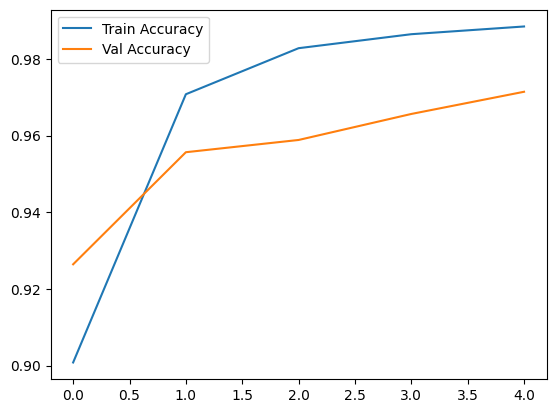

In [43]:
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.legend()
plt.show()

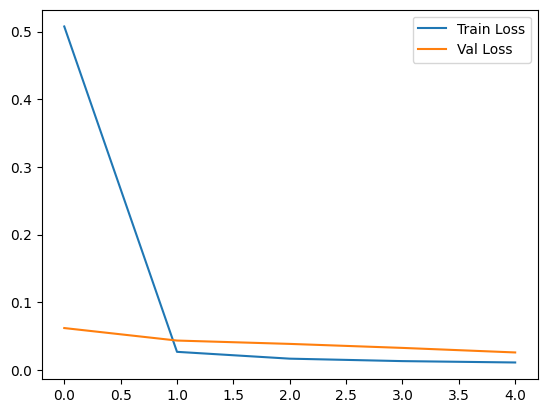

In [44]:
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend()
plt.show()

In [48]:
y_pred_test = model.predict([test_pairs[:,0], test_pairs[:,1]])

313/313 [==============================] - 1s 2ms/step


In [54]:
y_pred_test[0]

array([0.06727626], dtype=float32)

In [60]:
def visualize_results(left, right, pred):
  subplot = plt.subplot(1,2,1)
  plt.imshow(left)
  subplot.axis("off")
  subplot = plt.subplot(1,2,2)
  subplot.axis("off")
  plt.title(pred)
  plt.imshow(right)
  plt.show()

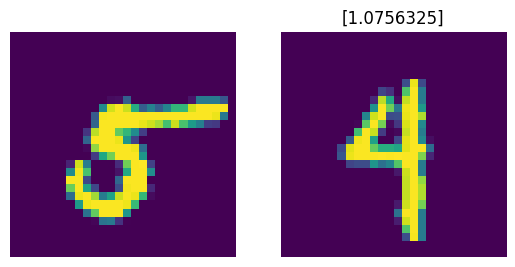

In [74]:
visualize_results(test_pairs[:, 0][-2], test_pairs[:, 1][-2], y_pred_test[-2])

In [69]:
np.unique(train_labels, return_counts=True)

(array([0., 1.], dtype=float32), array([52219,  7781]))

In [72]:
test_labels[-1:-10:-1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)